# Setup

In [ ]:
import numpy as np
from scipy.stats import ortho_group
import torch
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

In [2]:
color1 = '#66c2a5'
color2 = '#fc8d62'
color3 = '#8da0cb'

In [ ]:
# This block installs latex on the machine, used in the plot axes labels. Run this block if needed.
#!apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [3]:
# Using Latex in Pyplot
plt.rcParams.update({
    "text.usetex": True,
})

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Bilevel - 2NN

As discussed in the paper, for the special case of 2 layer nural networks with the squared error loss, the bilevel approach reduces to a kernel learning problem. When using $m$ particles, the discretized bilevel measure is given by $\eta = \frac{1}{m}\sum_{i=1}^m\delta_{w_i}$, where $w_i \in \mathbb{S}^d$ is the weight of the $i$th particle. We collect $(w_i)$ into the rows of the matrix $W \in \mathbb{R}^{m \times (d+1)}$. We also denote the input data with $X \in \mathbb{R}^{n \times (d+1)}$ and the labels with $y \in \mathbb{R}^n$. Then, the kernel matrix is given by
$$K(\eta) = \frac{1}{m}\sum_{i=1}^n\varphi(Xw_i)\varphi(Xw_i)^\top = \frac{1}{m}\varphi(XW^\top)\varphi(XW^\top)^\top.$$
Furthermore, the parameterizing signed measure $\nu$ is also supported on $(w_i)$ and given by $\mathrm{d}\nu(w) = f(w)\mathrm{d}\eta(w)$, where
$f(w) = \varphi(Xw)^\top (K(\eta) + n\lambda I)^{-1}y$. It is then straightforward to compute the original cost function at $\nu$,
\begin{align}
    G_{\lambda}(\nu) &= \frac{1}{2n}\left\Vert y - \int \varphi(Xw)\mathrm{d}\nu(w)\right\Vert^2 + \frac{\lambda}{2}\Vert \nu\Vert_{\mathrm{TV}}^2\\
    &= \frac{n\lambda^2}{2}\Vert (K(\eta) + n\lambda I)^{-1}y\Vert^2 + \frac{\lambda}{2}\left(\frac{1}{m}\sum_{i=1}^m\vert f(w_i)\vert\right)^2
\end{align}
We also recall from the paper that the bilevel cost and its first variation are given by
$$J(\eta) = \frac{\lambda}{2} y^\top (K(\eta) + n\lambda I)^{-1}y, \quad J'[\eta](w) = -\frac{\lambda}{2}\left(\varphi(Xw)^\top (K(\eta) + n\lambda I)^{-1} y\right)^2,$$
For notational simplcitiy, define $v_\eta = (K(\eta) + n\lambda I)^{-1}y$, and let $\bar{X} = v \circ X := ((v_\eta)_1x_1^\top,...,(v_\eta)_nx_n^\top)^\top \in \mathbb{R}^{n \times (d+1)}$. For our implementation, we will require computing the (Euclidean) gradient of $J'[\eta](w)$ w.r.t. $w$, which as a row vector is given by
$$\nabla_{w^\top} J'[\eta](w) = -\lambda \big(\varphi(w^\top X^\top)v_\eta\big)\big(\varphi'(w^\top X^\top)\bar{X}\big).$$
Recall that $\nabla_{w_i}J'[\eta](w_i) = m\nabla_{w_i}J\Big(\frac{1}{m}\sum_{j=1}^m\delta_{w_j}\Big)$. This is useful as it implies that for a fair comparison with the lifting approach, we should rescale the gradients from the lifting cost with a prefactor of $m$ as well.

We can vectorize the gradients with respect to the collection of weights $W$ as
$$\nabla_W J'[\eta] = -\lambda \big(\varphi(WX^\top)v_\eta\big) \circ \big(\varphi'(WX^T)\bar{X}\big).$$
The following code contains the implementation of the above formulas:

In [5]:
def bilevel_pred(W, X_test, X_train, y_train, phi, reg_param):
    m = W.shape[0]
    n = X_train.shape[0]
    K_inv = torch.linalg.inv(bilevel_kernel(W, X_train, phi) + n * reg_param * torch.eye(n, device=device))
    v = K_inv @ y_train
    return 1 / m * phi(X_test @ W.T) @ phi(W @ X_train.T) @ v

def bilevel_kernel(W, X, phi):
    n, m = X.shape[0], W.shape[0]
    post_phi = 1 / np.sqrt(m) * phi(X @ W.T)
    return post_phi @ post_phi.T

def bilevel_cost(W, X, y, phi, reg_param):
    n = X.shape[0]
    K_inv = torch.linalg.inv(bilevel_kernel(W, X, phi) + n * reg_param * torch.eye(n, device=device))
    return reg_param / 2 * y.T @ K_inv @ y

def bilevel_original_cost(W, X, y, phi, reg_param):
    n = X.shape[0]
    K_inv = torch.linalg.inv(bilevel_kernel(W, X, phi) + n * reg_param * torch.eye(n, device=device))
    v = K_inv @ y
    return n * reg_param ** 2 / 2 * torch.linalg.norm(v) ** 2 + \
            reg_param / 2 * torch.mean(torch.abs(phi(W @ X.T) @ v)) ** 2

def bilevel_firstvar_grad(W, X, y, phi, phiprime, reg_param):
    n = X.shape[0]
    v = torch.linalg.inv(bilevel_kernel(W, X, phi) + n * reg_param * torch.eye(n, device=device)) @ y
    v_1 = phi(W @ X.T) @ v
    V_2 = phiprime(W @ X.T) @ (X * v.reshape(-1,1))
    return - reg_param * V_2 * v_1.reshape(-1, 1)

def relu(z):
    return torch.maximum(z, torch.tensor([0.], device=device))

def reluprime(z):
    return 1.0 * (z >= 0)

def proj_to_sphere(Z):
    return Z / torch.linalg.norm(Z, axis=1).reshape(-1, 1)

def bilevel_experiment(X, y, phi, phiprime, reg_param, stepsize,
                               max_iter, spherical=True, temp = 0.0,
                               zero_temp_after=None, return_weights=False,
                               mute=False, zero_stepsize_after=None):
    d = X.shape[1]
    W = proj_to_sphere(torch.randn(m, d).to(device))
    values = []
    for i in range(max_iter):
        if zero_temp_after is not None and zero_temp_after < i:
            temp = 0
        if zero_stepsize_after is not None and zero_stepsize_after < i:
            stepsize = 0
        values.append(bilevel_original_cost(W, X, y, phi, reg_param).cpu())
        if not mute and i % (max_iter // 20) == 0:
            print(values[-1])
            print(bilevel_cost(W, X, y, phi, reg_param).cpu())
            print()
        new_W = W - stepsize * bilevel_firstvar_grad(W, X, y, phi, phiprime, reg_param) \
            + np.sqrt(2 * stepsize * temp) * torch.randn(m, d).to(device)
        if spherical:
            W = proj_to_sphere(new_W)
        else:
            W = new_W
    if return_weights:
        return values, W
    else:
        return values

# Lifting - 2NN



Here, $\nu$ is parameterized using $m$ particles $(r_i,w_i)_{i=1}^m$ where $r_i \in \mathbb{R}$ and $w_i \in \mathbb{S}^d$ via $\nu = \frac{1}{m}\sum_{i=1}^mr_i\delta_{w_i}$, leading to the prediction function $\hat{y}_\nu(X) = \frac{1}{m}\varphi(XW^\top)r$ for inputs $X \in \mathbb{R}^{n \times (d+1)}$. With a choice of $b=2$ in the paper, the lifted cost function is given by
$$F_{\lambda,2}(W,r) = \frac{1}{2n}\Vert y - \hat{y}_\nu(X)\Vert^2 + \frac{\lambda}{2m}\Vert r\Vert^2.$$
Further, the original cost function is given by,
$$G_\lambda(\nu) = \frac{1}{2n}\Vert y - \hat{y}_\nu(X)\Vert^2 + \frac{\lambda}{2}\left(\frac{1}{m}\sum_{i=1}^m\vert r_i\vert\right)^2.$$
We can then write the adjusted Euclidean gradient of the lifted cost with respect to $r \in \mathbb{R}^m$ as
$$m\cdot \nabla_r F_{\lambda,2}(W,r) = \frac{1}{n}\varphi(WX^\top)(\hat{y}_\nu(x) - y).$$
Similarly, it is straightforward to verify that
$$m\cdot \nabla_W F_{\lambda,2}(W,r) = (r \circ \varphi'(WX^\top)) ((\hat{y}_\nu(X) - y)\circ X).$$
The choice of the lifting metric, i.e. canonical vs conic, will affect how we perform the gradient descent updates. In other words, we can compute the gradients with respect to the metric
$$\left\langle \begin{pmatrix} \delta r_1\\ \delta w_1\end{pmatrix}, \begin{pmatrix}\delta r_2\\ \delta w_2\end{pmatrix}\right\rangle_{(r,w)} = \vert a\vert^{q_r-2}\delta r_1\delta r_2 + \vert r\vert^{q_w}\langle \delta w_1,\delta w_2\rangle_w.$$
Then we have,
$$m \cdot \mathrm{grad}_a F_{\lambda,2}(W,r) = \vert r\vert^{2-q_r} m\cdot \nabla_a F_{\lambda,2}(W,r),$$
and
$$m \cdot \mathrm{grad}_W F_{\lambda,2}(W,r) = \vert r\vert^{-q_w} m\cdot \nabla_W F_{\lambda,2}(W,r).$$
The gradients with respect to the two metrics coincide when $q_r = 2$ and $q_w = 0$, which corresponds to the canonical metric. The case $q_r = q_w = 1$, known as the conic metric, leads to a stepsize scaling with $\vert r\vert$.

The following code contains the implementation of the above formulas:

In [6]:
def lifting_pred(W, r, X, phi):
    m = W.shape[0]
    return 1 / m * phi(X @ W.T) @ r

def lifting_cost(W, r, X, y, phi, reg_param):
    return torch.mean((lifting_pred(W, r, X, phi) - y) ** 2) / 2 + reg_param / 2 * torch.mean(r ** 2)

def lifting_original_cost(W, r, X, y, phi, reg_param):
    return torch.mean((lifting_pred(W, r, X, phi) - y) ** 2) / 2 + reg_param / 2 * torch.mean(r ** 2) \
                + reg_param / 2 * torch.mean(torch.linalg.norm(W, dim=1))

def lifting_cost_firstvar_grad(W, r, X, y, phi, phiprime, reg_param):
    n = X.shape[0]
    yhat = lifting_pred(W, r, X, phi)
    V_1 = 1 / np.sqrt(n) * phiprime(W @ X.T) * r.reshape(-1, 1)
    V_2 = 1 / np.sqrt(n) * X * (yhat - y).reshape(-1, 1)
    grad_W = V_1 @ V_2
    grad_r = 1 / n * phi(W @ X.T) @ (yhat - y) + reg_param * r
    return (grad_W, grad_r)

def lifting_experiment(X, y, phi, phiprime, reg_param,
                     stepsize, max_iter, spherical=True, temp_w=0., temp_r=0.,
                     qr=2., qw=0., return_weights=False, mute=False):
    d = X.shape[1]
    W = proj_to_sphere(torch.randn(m, d).to(device))
    r = torch.randn(m).to(device)
    values = []
    for i in range(max_iter):
        grad_W, grad_r = lifting_cost_firstvar_grad(W, r, X, y, phi, phiprime, reg_param)
        W_update = W - stepsize * (torch.abs(r) ** (-qw)).reshape(-1, 1) * grad_W + np.sqrt(2 * stepsize * temp_w) * torch.randn(m, d).to(device)
        if spherical:
            W = proj_to_sphere(W_update)
        else:
            W = W_update
        r = r - stepsize * (torch.abs(r) ** (2 - qr)) * grad_r + np.sqrt(2 * stepsize * temp_r) * torch.randn(m).to(device)
        values.append(lifting_original_cost(W, r, X, y, phi, reg_param).cpu())
        if not mute and i % (max_iter // 20) == 0:
            print(values[-1])
            print(lifting_cost(W, r, X, y, phi, reg_param).cpu())
            print()
    if return_weights:
        return values, r, W
    else:
        return values

# Comaprisons

Define various activations:

In [7]:
def teacher(W, r, X, act):
    return act(X @ W.T) @ r

def h3(z):
    return (z ** 3 - 3 * z) / np.sqrt(6)

def h4(z):
    return (z ** 4 - 6 * (z ** 2) + 3) / np.sqrt(24)

def h3prime(z):
    return 3 * (z ** 2 - 3) / np.sqrt(6)

def h4prime(z):
    return (4 * (z ** 3) - 12 * z) / np.sqrt(24)

def Dirichlet(z, nf=4):
    return torch.sin((2 * nf + 1) * torch.pi * z) / torch.sin(torch.pi * z)

def Dirichlet_prime(z, nf=4):
    num_1 = (2 * nf + 1) * torch.pi * torch.cos((2 * nf + 1) * torch.pi * z) * torch.sin(torch.pi * z)
    num_2 = torch.pi * torch.sin((2 * nf + 1) * torch.pi * z) * torch.cos(torch.pi * z)
    return (num_1 - num_2) / (torch.sin(torch.pi * z) ** 2)

def D1(z):
    return Dirichlet(z, nf=1)

def D1_prime(z):
    return Dirichlet_prime(z, nf=1)

Generate the data from a teacher two-layer neural network with `h4` as its activation:



In [8]:
def generate_data(m, n, d, m_true):
    X = torch.randn(n, d).to(device)
    X_aug = torch.cat((X, torch.ones((n,1), device=device)), dim=1)
    W_true = torch.tensor(ortho_group.rvs(dim=max(d + 1, m_true))[:m_true], dtype=X_aug.dtype).to(device)
    a_true = 3 * torch.randn(m_true).to(device) / np.sqrt(m_true)
    y = teacher(W_true, a_true, X_aug, h4).to(device)
    return X_aug, y

## MFLD-Bilevel, Noisy vs Not

Repeat the experiment 5 times:

In [9]:
m, n, d, m_true = 1000, 100, 10, 5
num_experiments = 5

bilevel_nonoise_vals_all = []
bilevel_noisy_vals_all = []
for i in range(num_experiments):
    print(f'Round: {i}')
    X_aug, y = generate_data(m, n, d, m_true)
    bilevel_nonoise_vals = bilevel_experiment(X=X_aug, y=y, phi=relu, phiprime=reluprime,
                                                  reg_param=0.1/n, stepsize=0.01, max_iter=5000,
                                                  spherical=True, temp=0.0, mute=True)
    bilevel_noisy_vals = bilevel_experiment(X=X_aug, y=y, phi=relu, phiprime=reluprime,
                                                  reg_param=0.1/n, stepsize=0.01, max_iter=5000,
                                                  spherical=True, temp=0.001,
                                                  zero_temp_after=3000, mute=True)
    bilevel_nonoise_vals_all.append(bilevel_nonoise_vals)
    bilevel_noisy_vals_all.append(bilevel_noisy_vals)
bilevel_nonoise_vals_all = torch.tensor(bilevel_nonoise_vals_all)
bilevel_noisy_vals_all = torch.tensor(bilevel_noisy_vals_all)

Round: 0
Round: 1
Round: 2
Round: 3
Round: 4


Normalize cost values by subtracting the minimum value achieved at each experiment, and calculate the mean over the 5 experiments:

In [10]:
bilevel_nonoise_means = bilevel_nonoise_vals_all.mean(dim=0)
bilevel_noisy_means = bilevel_noisy_vals_all.mean(dim=0)

bilevel_nonoise_vals_all_normalized = bilevel_nonoise_vals_all - bilevel_noisy_vals_all[:,-1].reshape(-1, 1)
bilevel_noisy_vals_all_normalized = bilevel_noisy_vals_all - bilevel_noisy_vals_all[:,-1].reshape(-1,1)

bilevel_nonoise_normalized_means = bilevel_nonoise_vals_all_normalized.mean(dim=0)
bilevel_noisy_normalized_means = bilevel_noisy_vals_all_normalized.mean(dim=0)

Plot the values:

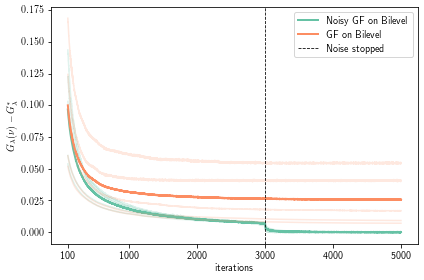

In [11]:
# Proper figure size for publication
# plt.figure(figsize=(6.4 / 1.5, 4.8 / 1.5))

plt.xlabel('iterations')
plt.ylabel(r'$G_\lambda(\nu) - G_\lambda^*$')
plt.plot(bilevel_noisy_normalized_means[100:], label='Noisy GF on Bilevel', c=color1, linewidth=2)

for i in range(num_experiments):
    plt.plot(bilevel_noisy_vals_all_normalized[i][100:], c=color1, alpha=0.2)

plt.plot(bilevel_nonoise_normalized_means[100:], label='GF on Bilevel', c=color2, linewidth=2)
for i in range(num_experiments):
    plt.plot(bilevel_nonoise_vals_all_normalized[i][100:], c=color2, alpha=0.2)

plt.axvline(2900, linestyle='--', color='black', label='Noise stopped', linewidth=0.8)
plt.xticks([0, 900, 1900, 2900, 3900, 4900], [100, 1000, 2000, 3000, 4000, 5000])
plt.legend()
plt.tight_layout()
# Save the figure for publication
# plt.savefig('bilevel_noise_vs_nonoise.pdf')
plt.show()

## MFLD-Bilevel vs MFLD-Lifted

Repeat the experiment 5 times (we stop the bilevel dynamics after 5000 iterations to save compute as it converges much faster and remains the same for the rest of the iterations):

In [13]:
m, n, d, m_true = 1000, 100, 10, 5
num_experiments = 5
iterations = 50000

bilevel_all_vals = []
lifting_canonical_all_vals = []
lifting_conic_all_vals = []
for i in range(num_experiments):
    print(f'Round: {i}')
    X_aug, y = generate_data(m, n, d, m_true)
    bilevel_vals = bilevel_experiment(X=X_aug, y=y, phi=relu, phiprime=reluprime,
                                                  reg_param=0.1/n, stepsize=0.001, max_iter=5000,
                                                  spherical=True, temp=0.001,
                                                  mute=True)
    # bilevel becomes constant after 5000, the next line is to save compute
    bilevel_vals = bilevel_vals + [bilevel_vals[-1]] * (iterations - 5000)

    lifting_canonical_vals = lifting_experiment(X=X_aug, y=y, phi=relu, phiprime=reluprime,
                                       reg_param = 0.1/n, stepsize=0.001,
                                       max_iter=iterations, spherical=True,
                                       temp_w=0.001, temp_r=0.001,
                                       qr=2., qw=0., mute=True)

    lifting_conic_vals = lifting_experiment(X=X_aug, y=y, phi=relu, phiprime=reluprime,
                                       reg_param = 0.1/n, stepsize=0.001,
                                       max_iter=iterations, spherical=True,
                                       temp_w=0.001, temp_r=0.001,
                                       qr=1., qw=1., mute=True)
    bilevel_all_vals.append(bilevel_vals)
    lifting_canonical_all_vals.append(lifting_canonical_vals)
    lifting_conic_all_vals.append(lifting_conic_vals)

bilevel_all_vals = torch.tensor(bilevel_all_vals)
lifting_canonical_all_vals = torch.tensor(lifting_canonical_all_vals)
lifting_conic_all_vals = torch.tensor(lifting_conic_all_vals)

Round: 0
Round: 1
Round: 2
Round: 3
Round: 4


Normalize cost values by subtracting the minimum value achieved at each experiment, and calculate the mean over the 5 experiments:

In [14]:
bilevel_vals_means = bilevel_all_vals.mean(dim=0)
lifting_canonical_vals_means = lifting_canonical_all_vals.mean(dim=0)
lifting_conic_vals_means = lifting_conic_all_vals.mean(dim=0)

bilevel_normalized = bilevel_all_vals - bilevel_all_vals[:, -1].reshape(-1, 1)
lifting_canonical_normalized = lifting_canonical_all_vals - bilevel_all_vals[:, -1].reshape(-1, 1)
lifting_conic_normalized = lifting_conic_all_vals - bilevel_all_vals[:, -1].reshape(-1, 1)

bilevel_normalized_means = bilevel_normalized.mean(dim=0)
lifting_canonical_normalized_means = lifting_canonical_normalized.mean(dim=0)
lifting_conic_normalized_means = lifting_conic_normalized.mean(dim=0)

Plot the values:

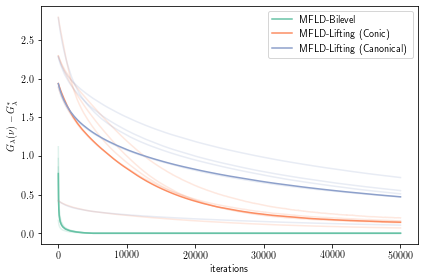

In [15]:
# To view in the notebook
plt.xlabel('iterations')
plt.ylabel(r'$G_\lambda(\nu) - G_\lambda^*$')

for i in range(num_experiments):
    plt.plot(bilevel_normalized[i], c=color1, alpha=0.2)

plt.plot(bilevel_normalized_means, label='MFLD-Bilevel', c=color1)
for i in range(num_experiments):
    plt.plot(lifting_conic_normalized[i], c=color2, alpha=0.2)

plt.plot(lifting_conic_normalized_means, label='MFLD-Lifting (Conic)', c=color2)
for i in range(num_experiments):
    plt.plot(lifting_canonical_normalized[i], c=color3, alpha=0.2)

plt.plot(lifting_canonical_normalized_means, label='MFLD-Lifting (Canonical)', c=color3)
plt.legend()
plt.tight_layout()

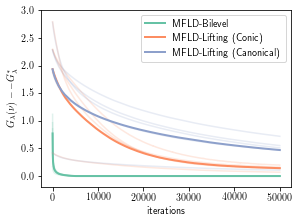

In [16]:
# To save for publication
# fig, ax = plt.subplots())
plt.figure(figsize=(6.4 / 1.5, 4.8 / 1.5))

plt.xlabel('iterations')
plt.ylabel(r'$G_\lambda(\nu) -  - G_\lambda^*$')
plt.ylim(top=3.,bottom=-0.2)

for i in range(5):
    plt.plot(bilevel_normalized[i], c=color1, alpha=0.2)

plt.plot(bilevel_normalized_means, label='MFLD-Bilevel', c=color1, linewidth=2)
for i in range(5):
    plt.plot(lifting_conic_normalized[i], c=color2, alpha=0.2)

plt.plot(lifting_conic_normalized_means, label='MFLD-Lifting (Conic)', c=color2, linewidth=2)
for i in range(5):
    plt.plot(lifting_canonical_normalized[i], c=color3, alpha=0.2)

plt.plot(lifting_canonical_normalized_means, label='MFLD-Lifting (Canonical)', c=color3, linewidth=2)
plt.legend()

plt.tight_layout()
# plt.savefig('bilevel_vs_lifting.pdf')